In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, Rescaling
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


pd.set_option('display.precision', 3)

# Advanced deep learning techniques with keras

## Setup

### Load data: MNIST digits

In [2]:
# Load data with predefined train/test split
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

# Decrease the size of train set for quicker computations
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, train_size=10000, random_state=20250324, stratify=y_train_full)

# Feature engineering
num_classes = 10
y_sets = [y_train, y_test, y_val]
y_train, y_test, y_val = [to_categorical(y, num_classes=num_classes) for y in y_sets]

x_sets = [X_train, X_test, X_val]
X_train, X_test, X_val = [Rescaling(1./255)(x) for x in x_sets]

### Helper functions

In [3]:
def plot_history(fit_history, metric="accuracy"):
    plt.plot(fit_history[metric], label='Training')
    plt.plot(fit_history[f'val_{metric}'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(f'{metric} history on training and validation sets')
    plt.legend()
    plt.show()

In [4]:
class ResultCollector:
    def __init__(self):
        self.results = {}
        
    def add_model(self, name, train_acc, test_acc):
        """Add or update a model's results."""
        self.results[name] = {
            'Train Accuracy': train_acc,
            'Test Accuracy': test_acc
        }
        return self.get_table()
    
    def get_table(self):
        """Get the results table with optional styling."""
        df = pd.DataFrame(self.results).T
        return df.style.format("{:.3f}").background_gradient(cmap='RdYlGn', axis=None)
    
results = ResultCollector()

## Convolution with keras

Convolutional layers are designed to operate on images or time-series data with multiple sensors, so they expect input data to have a channel dimension. In our case, since we are dealing with grayscale images, we will have only one channel (unlike the RGB channels in color images). To ensure our data has this channel dimension, we need to reshape our data first. Let's collect all the preprocessing steps, and create new preprocessed sets.

In [5]:
from keras.layers import Reshape

preprocess = Sequential([
    Input(shape=X_train.shape[1:]),
    Reshape(target_shape=(X_train.shape[1], X_train.shape[2], 1))  # explicitly state the 4th (channel) dimension
])

In [6]:
X_train.shape

TensorShape([10000, 28, 28])

In [7]:
preprocess(X_train).shape

TensorShape([10000, 28, 28, 1])

*Question*: Why are there no `compile()` and `fit()` steps?

<details>
<summary>Answer</summary>

This model only contains deterministic transformations with no trainable parameters. Thus, we don't need an optimizer, loss function, or metrics. We can just call it directly on our data as a function to transform inputs.

</details>

</br>



In [8]:
from keras.layers import Conv2D, MaxPooling2D

cnn_layers = Sequential([
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Create the model
model_cnn = Sequential([
    preprocess,
    cnn_layers
])

# Compile the model
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_cnn.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 10)             │        34,826 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

None


In [13]:
print(cnn_layers.summary())
# 32*(3*3+1)
# 64*(32*3*3+1) -- bias term is not channel-specific as it does not depend on the input data
# (64*5*5)*10+10

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
# Fit the model
history_cnn = model_cnn.fit(
    X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=512,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)]
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.2960 - loss: 2.1469 - val_accuracy: 0.7933 - val_loss: 1.2572
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.7200 - loss: 1.0568 - val_accuracy: 0.8798 - val_loss: 0.4274
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.8483 - loss: 0.4790 - val_accuracy: 0.9156 - val_loss: 0.2958
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.8957 - loss: 0.3478 - val_accuracy: 0.9333 - val_loss: 0.2351
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9143 - loss: 0.2791 - val_accuracy: 0.9416 - val_loss: 0.2004
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9305 - loss: 0.2222 - val_accuracy: 0.9502 - val_loss: 0.1742
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9378 - loss: 0.2014 - val_accuracy: 0.9550 - val_loss: 0.1568
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9445 - loss: 0.1845 - val_accuracy: 0.

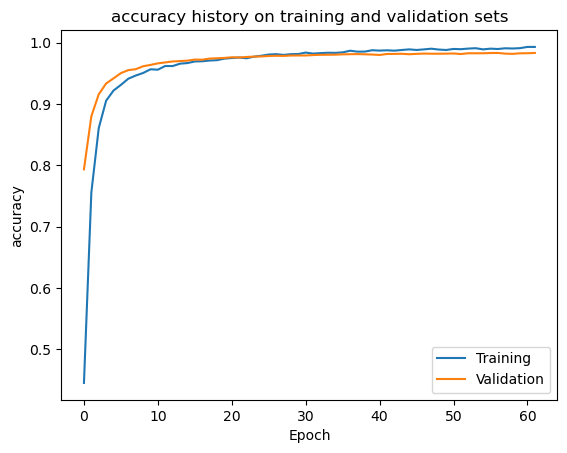

In [10]:
plot_history(history_cnn.history)

In [11]:
train_loss, train_accuracy = model_cnn.evaluate(X_train, y_train)
test_loss, test_accuracy = model_cnn.evaluate(X_val, y_val)
results.add_model("Convolutional Neural Network", train_accuracy, test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9978 - loss: 0.0082
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9827 - loss: 0.0645


,Train Accuracy,Test Accuracy
Convolutional Neural Network,0.998,0.983


## Other useful tricks: data augmentation

We can exploit the fact that slight modifications of the images preserve the relevant nature of the images while changing all the pixels. This way, we could create new data from the existing samples.

Below, we create a new sequential operation applying two such transformations on the digits: rotation and zoom. The first parameters specifies the maximum amount of transformation, the second one how to fill values for the newly created pixels (here: fill with the value of the nearest pixels).

Data augmentation layers in Keras like `RandomRotation` and `RandomZoom` are designed to work with batches of images, not individual images.

In [13]:
from keras.layers import RandomRotation, RandomZoom

data_augmentation = Sequential([
    RandomRotation(0.05, fill_mode="nearest"),  # randomly rotate the pics any direction by 10% the most
    RandomZoom(0.05, fill_mode="nearest")  # zoom in/out by 10% the most
])

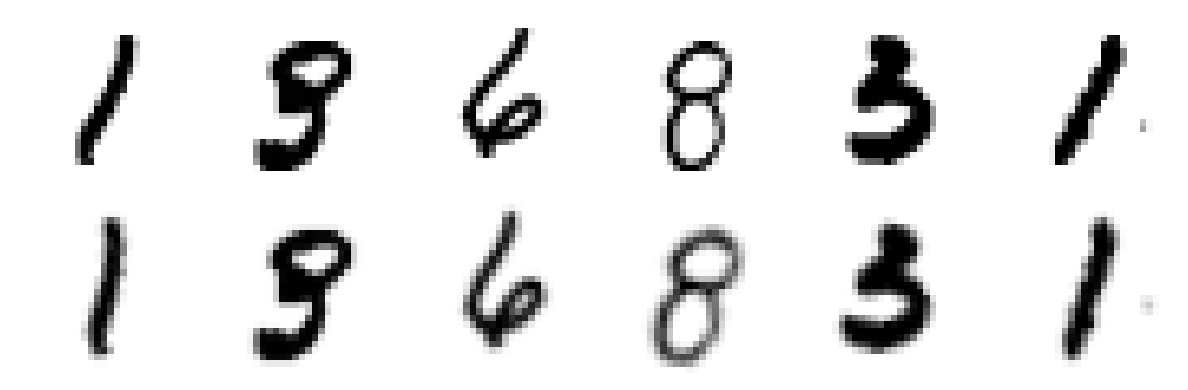

In [14]:
# Get a batch of sample images
number_of_digits_to_show = 6
sample_images = X_train[:number_of_digits_to_show]

# Preprocess and augment them all at once
preprocessed_images = preprocess(sample_images)
augmented_images = data_augmentation(preprocessed_images)

# Look at the transformations
fig, axs = plt.subplots(2, number_of_digits_to_show, figsize=(2*number_of_digits_to_show, 4))

for i in range(number_of_digits_to_show):
    # Display preprocessed images (top row)
    axs[0, i].imshow(preprocessed_images[i], cmap="binary")
    axs[0, i].axis("off")
    
    # Display augmented images (bottom row)
    axs[1, i].imshow(augmented_images[i], cmap="binary")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

In [20]:
model_cnn_with_da = Sequential([
    preprocess,
    data_augmentation,
    cnn_layers
])

print(data_augmentation.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation                 │ (6, 28, 28, 1)         │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (6, 28, 28, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


As we include the layers of the previously trained model (`cnn_layers`), the weights are already optimized. So here we will check if data augmentation could improve the CNN's performance.

In [21]:
# Fit the model
model_cnn_with_da.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cnn_with_da = model_cnn_with_da.fit(
    X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=512,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=10)] # increase patience for slower learning
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.2936 - loss: 2.1347 - val_accuracy: 0.7979 - val_loss: 1.1071
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.6734 - loss: 1.1016 - val_accuracy: 0.8749 - val_loss: 0.4305
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.7989 - loss: 0.6243 - val_accuracy: 0.9102 - val_loss: 0.3113
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.8579 - loss: 0.4592 - val_accuracy: 0.9283 - val_loss: 0.2455
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.8945 - loss: 0.3554 - val_accuracy: 0.9403 - val_loss: 0.2063
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9020 - loss: 0.3276 - val_accuracy: 0.9471 - val_loss: 0.1780
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9192 - loss: 0.2816 - val_accuracy: 0.9534 - val_loss: 0.1582
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9191 - loss: 0.2577 - val_accuracy: 0

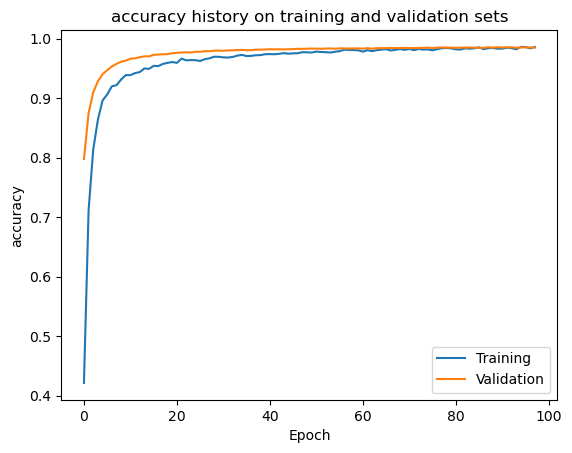

In [23]:
plot_history(history_cnn_with_da.history)

In [24]:
train_loss, train_accuracy = model_cnn_with_da.evaluate(X_train, y_train)
test_loss, test_accuracy = model_cnn_with_da.evaluate(X_val, y_val)
results.add_model("CNN with Data augmentation", train_accuracy, test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9954 - loss: 0.0142
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9847 - loss: 0.0527


,Train Accuracy,Test Accuracy
Convolutional Neural Network,0.998,0.983
CNN with Data augmentation,0.996,0.985


## Unsupervised learning with neural networks: Auto-encoder

In [25]:
encoding_dimension = 154  # to compare with PCA of the previous class

encoder_layers = Sequential([
    Input(shape=X_train.shape[1:]),
    Flatten(),
    Dense(encoding_dimension, activation='relu')
])

decoder_layers = Sequential([
    Input(shape=(encoding_dimension,)),
    Dense(X_train.shape[1] * X_train.shape[2], activation='relu'),
    Reshape(target_shape=X_train.shape[1:])
])

autoencoder_model = Sequential([
    encoder_layers,
    decoder_layers
])

autoencoder_model.compile(optimizer='adam', loss='binary_crossentropy')  # we can think of the rescaled pixels as probabilities of being black

# we can summarize our model.
autoencoder_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)       │ (None, 154)            │       120,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 28, 28)         │       121,520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,410 (946.91 KB)

 Trainable params: 242,410 (946.91 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Train the autoencoder
history_autoencoder = autoencoder_model.fit(
    X_train, X_train,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_data=(X_test, X_test)
)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6939 - val_loss: 0.2873
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2727 - val_loss: 0.2421
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2349 - val_loss: 0.2129
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2120 - val_loss: 0.1961
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1948 - val_loss: 0.1932
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1911 - val_loss: 0.1944
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1948 - val_loss: 0.1951
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1931 - val_loss: 0.2055
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2023 - val_loss: 0.1919
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1929 - val_loss: 0.2124
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2048 - val_loss: 0.2192
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2157 - val_lo

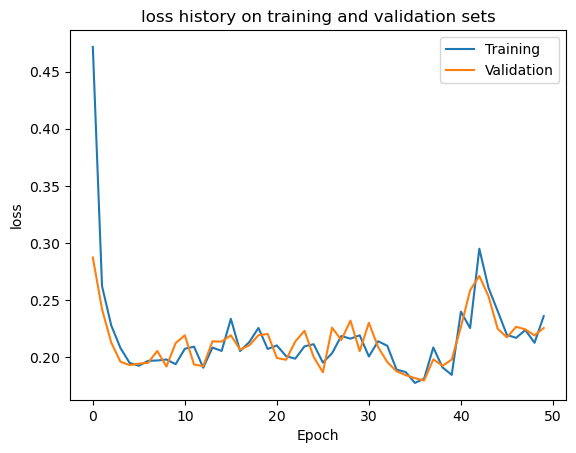

In [27]:
plot_history(history_autoencoder.history, metric="loss")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


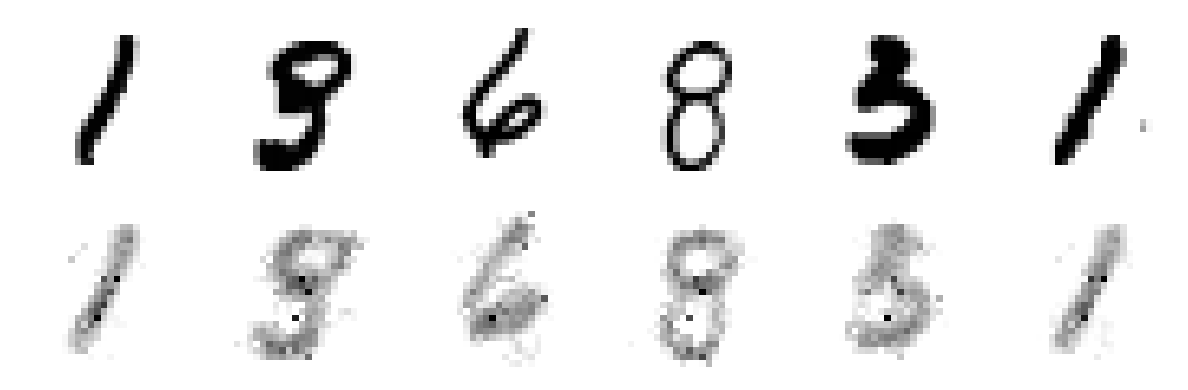

In [28]:
# Get a batch of sample images
number_of_digits_to_show = 6
sample_images = X_train[:number_of_digits_to_show]

reconstructed_img = autoencoder_model.predict(sample_images)


# Look at the transformations
fig, axs = plt.subplots(2, number_of_digits_to_show, figsize=(2*number_of_digits_to_show, 4))

for i in range(number_of_digits_to_show):
    # Display preprocessed images (top row)
    axs[0, i].imshow(sample_images[i], cmap="binary")
    axs[0, i].axis("off")
    
    # Display augmented images (bottom row)
    axs[1, i].imshow(reconstructed_img[i], cmap="binary")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

#### Create a new model with more aggressive compression

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_14 (Sequential)      │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_15 (Sequential)      │ (None, 28, 28)         │        25,872 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,992 (199.19 KB)

 Trainable params: 50,992 (199.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9179 - val_loss: 0.3623
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3329 - val_loss: 0.2971
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2931 - val_loss: 0.2817
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2775 - val_loss: 0.2641
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2598 - val_loss: 0.2546
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2534 - val_loss: 0.2501
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2485 - val_loss: 0.2436
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2411 - val_loss: 0.2366
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2380 - val_loss: 0.2400
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2375 - val_loss: 0.2311
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2296 - val_loss: 0.2244
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2226 - val_lo

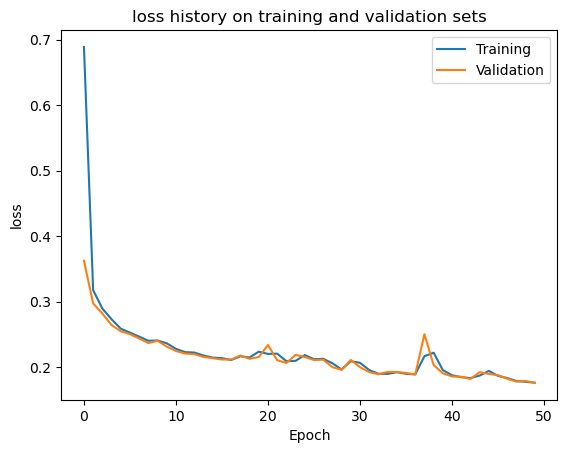

In [34]:
encoding_dimension = 32  # to compare with PCA of the previous class

encoder_layers = Sequential([
    Input(shape=X_train.shape[1:]),
    Flatten(),
    Dense(encoding_dimension, activation='relu')
])

decoder_layers = Sequential([
    Input(shape=(encoding_dimension,)),
    Dense(X_train.shape[1] * X_train.shape[2], activation='relu'),
    Reshape(target_shape=X_train.shape[1:])
])

autoencoder_model_32 = Sequential([
    encoder_layers,
    decoder_layers
])

autoencoder_model_32.compile(optimizer='adam', loss='binary_crossentropy')  # we can think of the rescaled pixels as probabilities of being black

# we can summarize our model.
autoencoder_model_32.summary()

history_autoencoder_32 = autoencoder_model_32.fit(
    X_train, X_train,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_data=(X_test, X_test)
)

plot_history(history_autoencoder_32.history, metric="loss")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


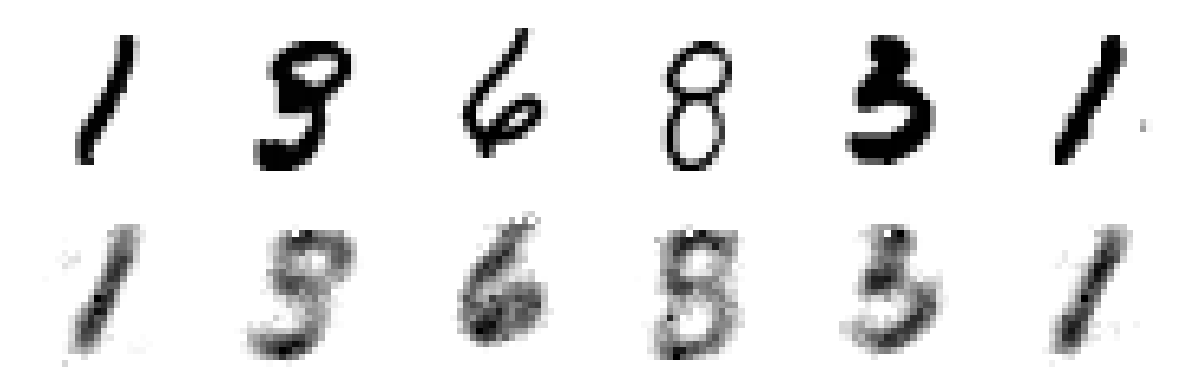

In [35]:
number_of_digits_to_show = 6
sample_images = X_train[:number_of_digits_to_show]

reconstructed_img = autoencoder_model_32.predict(sample_images)


# Look at the transformations
fig, axs = plt.subplots(2, number_of_digits_to_show, figsize=(2*number_of_digits_to_show, 4))

for i in range(number_of_digits_to_show):
    # Display preprocessed images (top row)
    axs[0, i].imshow(sample_images[i], cmap="binary")
    axs[0, i].axis("off")
    
    # Display augmented images (bottom row)
    axs[1, i].imshow(reconstructed_img[i], cmap="binary")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

This demonstrates the *"bottleneck principle"* in autoencoders: A properly sized bottleneck forces the model to learn efficient representations.

- Too narrow: loses important information (underfitting)
- Too wide: captures noise (overfitting)

How come that reconstruction error decreases while quality decreases?

- The model is optimizing for pixel-wise similarity (like MSE or binary cross-entropy)
- These metrics don't distinguish between meaningful structure and noise
- The model has no way to know which variations are "noise" vs "signal"


Autoencoders compress input into a latent space that captures important features. This could come handy when we have a few labeled examples but many unlabeled ones (typical real-world scenario). We can use all the unlabeled examples to learn a few important dimension ("feature-extraction) and use those limited number of features for the supervised learning task (this is called semi-supervised learning). Modern LLMs apply the same philosophy when learning contextual representations of text.

### Visualize the latent space

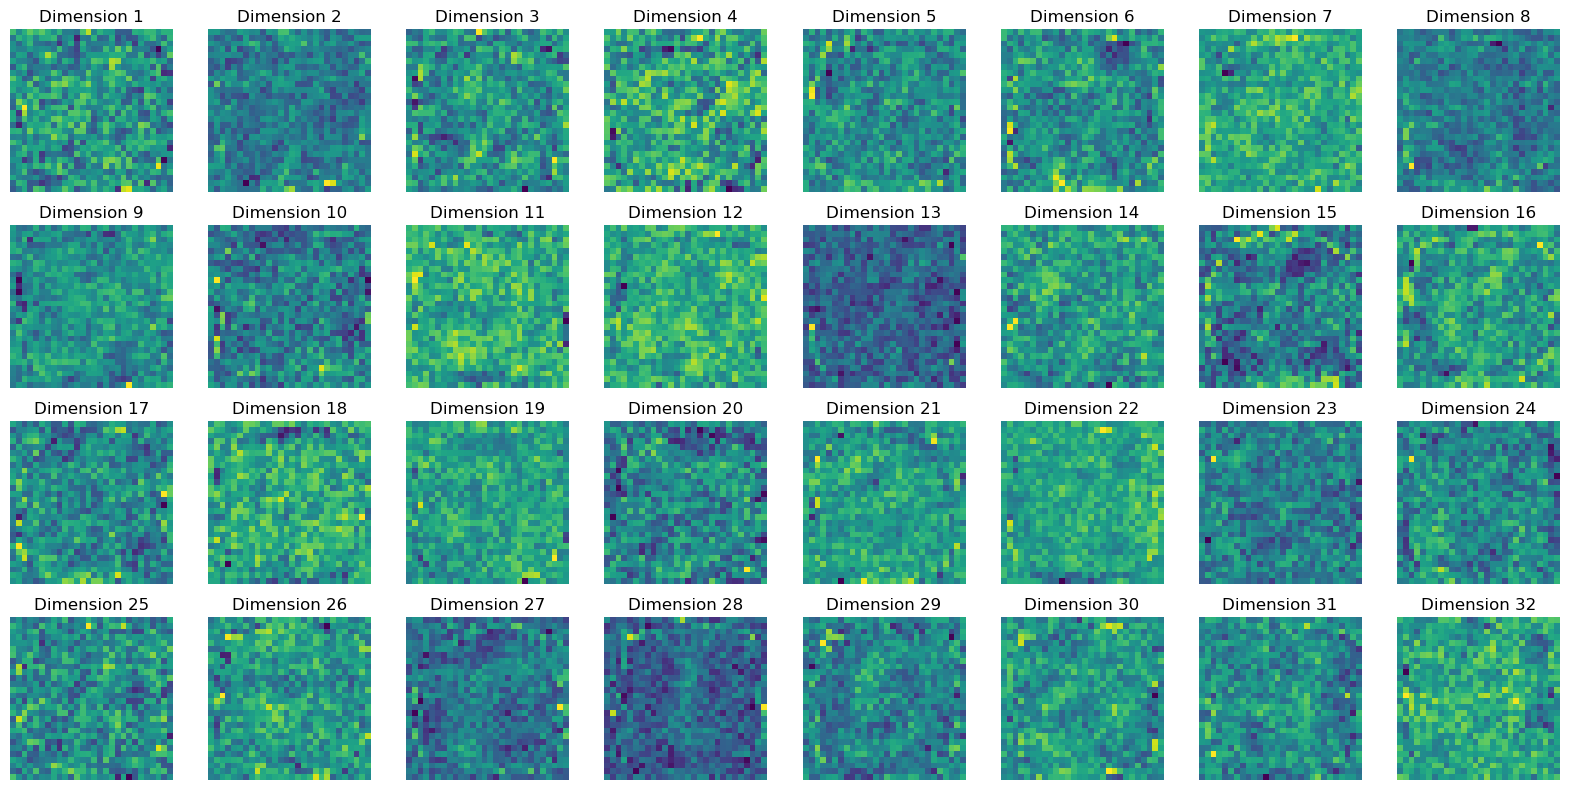

In [31]:
# Visualize the weights of the encoder layers

# Reshape the weights to 28x28 for each of the 32 dimensions
weights = encoder_layers.weights[0].numpy().reshape((28, 28, 32))

plt.figure(figsize=(16, 8))

# Plot each of the 32 weight grids
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(weights[:, :, i], cmap='viridis')
    plt.title(f'Dimension {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


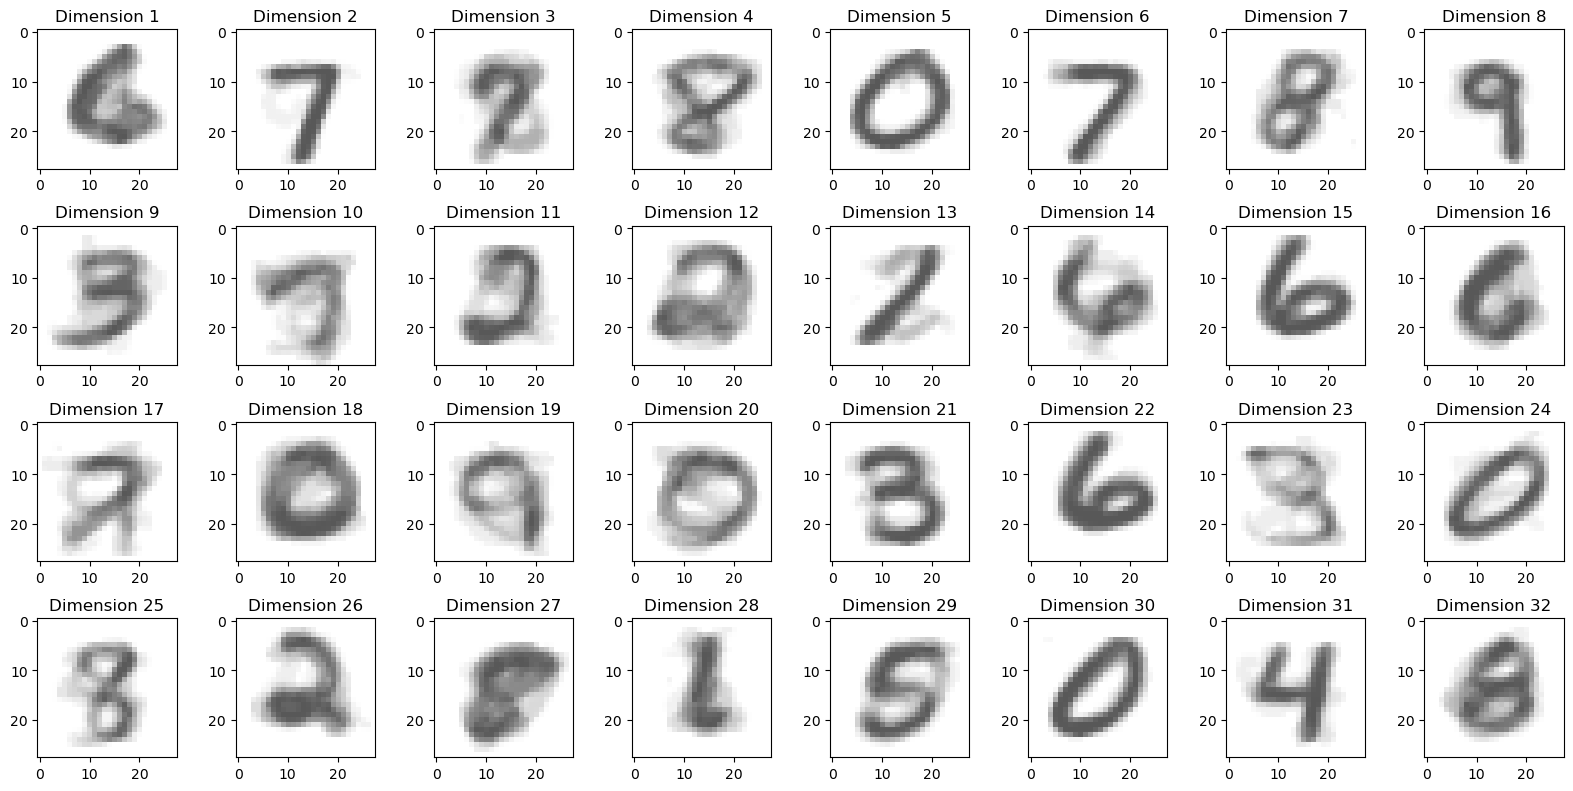

In [33]:
# Choose the top 10 images that maximally activate each dimension
encoder_predictions = encoder_layers.predict(X_test)
top_indices = np.argsort(encoder_predictions, axis=0)[-10:]

plt.figure(figsize=(16, 8))
for i in range(encoding_dimension):
    
    # Create a subplot for this dimension
    plt.subplot(4, 8, i+1)
    plt.title(f'Dimension {i+1}')
    
    # Display a stack of the top activating images
    for j in top_indices[:,i]:
        # Add the image with some offset for visualization
        plt.imshow(X_test[j], cmap='binary', alpha=0.1)
            
plt.tight_layout()